In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
!pip install --upgrade transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


In [4]:
from datasets import Dataset, DatasetDict

In [5]:
df1 = pd.read_csv('train.csv')

In [6]:
df2 = pd.read_csv('test.csv')

In [7]:
df1 = df1[['text','label']]

In [8]:
df2 = df2[['text','label']]

In [9]:
df=pd.concat([df1,df2],axis=0)

In [64]:
df

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1
...,...,...
2833,"* Her, a week ago: Precious, how are you? (I i...",0
2834,I don't have the ability to cope with it anymo...,1
2835,In case this is the first time you're reading ...,0
2836,Do you find this normal? They have a good rela...,0


In [65]:
# The code converts a Pandas DataFrame (df) into a Hugging Face Dataset and then configures the format of the dataset to be in PyTorch format.
dataset = Dataset.from_pandas(df)
dataset.set_format("pt")

In [66]:
dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 5676
})

In [67]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# (Bidirectional Encoder Representations from Transformers)

In [68]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [69]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5676 [00:00<?, ? examples/s]

In [70]:
tokenized_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5676
})

In [71]:
train_test = tokenized_dataset.train_test_split(test_size=0.4, seed=1178435)
train_test

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3405
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2271
    })
})

In [72]:
val_test = train_test['test'].train_test_split(test_size=0.5)
val_test

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1135
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1136
    })
})

In [73]:
df_train = pd.DataFrame( train_test['train'] )  # 60%
df_test = pd.DataFrame( train_test['test'] )    # 40%

In [74]:
df_train['label']=df_train['label'].apply(lambda x:x.numpy())
df_test['label']=df_test['label'].apply(lambda x:x.numpy())

<Axes: >

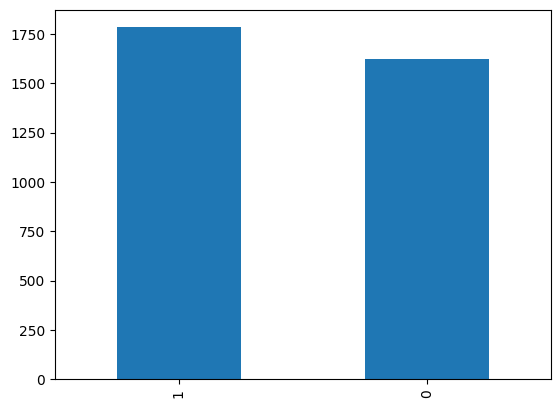

In [75]:
pd.value_counts(df_train['label']).plot.bar()

In [76]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [77]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [78]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to("cuda")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    optim="adafactor",
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True
)

In [121]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

In [122]:
y_preds = []
y_trues = []

In [123]:
def compute_metrics(eval_pred):
  pred, labels=eval_pred
  pred=np.argmax(pred,axis=1)

  acc=accuracy_score(labels,pred)
  f_score=f1_score(labels, pred, average='weighted')

  y_preds.append(pred)
  y_trues.append(labels)

  return {'acc':acc, 'f_score':f_score}

In [124]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=val_test['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [125]:
# Train the model
trainer.train()

Step,Training Loss
500,0.011000


TrainOutput(global_step=639, training_loss=0.00976223565043418, metrics={'train_runtime': 385.2836, 'train_samples_per_second': 26.513, 'train_steps_per_second': 1.659, 'total_flos': 2687679430502400.0, 'train_loss': 0.00976223565043418, 'epoch': 3.0})

In [128]:
check = trainer.evaluate()

In [130]:
check['eval_acc']

0.9162995594713657

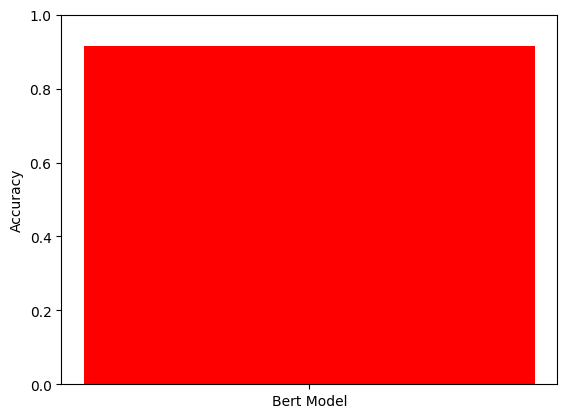

In [135]:
algorithms = ['Bert Model']
accuracies = [check['eval_acc']]

plt.bar(algorithms, accuracies, color='red', width=0.1)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [86]:
trainer.evaluate(train_test['test'])

{'eval_loss': 0.6324262619018555,
 'eval_acc': 0.9202994275649493,
 'eval_f_score': 0.9202736309724331,
 'eval_runtime': 27.594,
 'eval_samples_per_second': 82.301,
 'eval_steps_per_second': 5.146,
 'epoch': 8.0}

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
# model.save_pretrained('/content/drive/MyDrive/SCmodel')

In [105]:
scm = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/SCmodel").to("cpu")

In [94]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_test['train'],
#     eval_dataset=val_test['train'],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

In [99]:
# model = model.to("cuda")

In [96]:
# trainer.evaluate(val_test['test'])

{'eval_loss': 0.6268197894096375,
 'eval_acc': 0.9234154929577465,
 'eval_f_score': 0.9234342160176511,
 'eval_runtime': 15.2788,
 'eval_samples_per_second': 74.351,
 'eval_steps_per_second': 4.647}

In [106]:
inputs = tokenizer("she would do this, she knows I don't like play hitting, smacking, striking, hitting or violence of any sort on my person. Do I send out this vibe asking for it from the universe? Then yesterday I decided to take my friend to go help another ""friend"" move to a new place. While we were driving the friend we are moving strikes me on my shoulder. And I address it immediately because this is the 4th time I have told him not to do these things, then my other friend who is driving nearly gets into an collision with another car i think because he was high on marijuana and the friend we are moving in the backseat is like ""you have to understand I was just trying to get your attention"" you know the thing 5 year olds do to get peoples attention by smacking them, this guy is in his 60's.", padding="max_length", truncation=True, return_tensors="pt")

In [107]:
import torch
with torch.no_grad():
    logits = scm(**inputs).logits

predicted_class_id = logits.argmax().item()
ans = scm.config.id2label[predicted_class_id]

In [108]:
if ans == 'LABEL_1':
  print("Stress")
else:
  print("No Stress")

Stress


In [109]:
y_preds

[array([0, 0, 0, ..., 1, 0, 1]),
 array([0, 1, 0, ..., 0, 1, 0]),
 array([0, 0, 0, ..., 1, 0, 1])]

In [110]:
from keras.utils import to_categorical

y_categorial = to_categorical(y_preds[0])
y_pred = y_categorial.argmax(1)

In [111]:
y_trues

[array([0, 0, 0, ..., 1, 0, 1]),
 array([0, 1, 0, ..., 1, 1, 0]),
 array([0, 1, 0, ..., 1, 0, 1])]

In [112]:
y_trues_cat = to_categorical(y_trues[0])
y_true=y_trues_cat.argmax(1)

In [113]:
y_pred.tolist()[100]

1

In [114]:
y_pred

array([0, 0, 0, ..., 1, 0, 1])

In [115]:
y_trues_cat.tolist()[100]

[0.0, 1.0]

In [116]:
y_test_non_category = [int(np.argmax(t)) for t in y_trues_cat.tolist()[0] ]
y_predict_non_category = [ int(np.argmax(t)) for t in y_categorial.tolist()[0] ]

In [117]:
y_test_non_category

[0, 0]

In [118]:
confusion = confusion_matrix(y_true,y_pred)

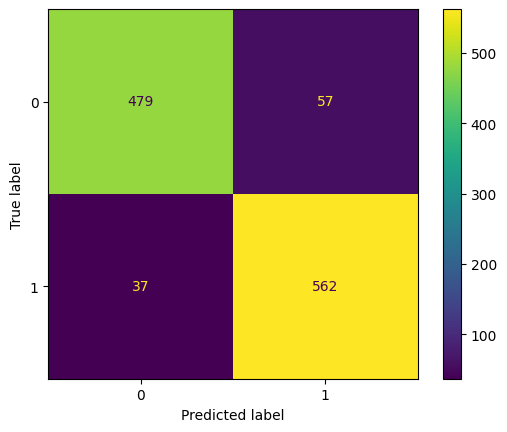

In [119]:

import matplotlib.pyplot as plt
disp=ConfusionMatrixDisplay(confusion)
disp.plot()
plt.show()
